In [15]:
# %matplotlib nbagg
import os
import datetime
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
today=datetime.date.today()

mypath = 'C:\\Researches\\Data\MPS3\\202104\\'
base = 'Co'
scans = np.array([14,15,21,16,17,18,20])

In [16]:
os.chdir(mypath)

def gaussian_norm(x,mu,sig,amp):
    norm = (1./(np.sqrt(2*np.pi)*sig))
    return amp*norm*np.exp(-((x-mu)**2)/(2*sig**2))

def fitpeak(data):
    center = np.argmax(data)
    xdata = np.arange(len(data))
    popt,pcov = curve_fit(gaussian_norm, xdata, data, p0=[center,10.,np.max(data)])
    mu = popt[0]
    sigma = popt[1]
    amp = popt[2]
    return mu,sigma,amp

def getdata(scannumber):
    global mypath
    global base
    
    if scannumber < 10:
        filename = mypath+'RIXS\\'+base+"_"+"000"+str(scannumber)
    elif scannumber < 100:
        filename = mypath+'RIXS\\'+base+"_"+"00"+str(scannumber)
    elif scannumber < 1000:    
        filename = mypath+'RIXS\\'+base+"_"+"0"+str(scannumber)
    else:    
        filename = mypath+base+"_"+str(scannumber)

    f1 = h5py.File(filename+"_d1.h5", 'r')
    f2 = h5py.File(filename+"_d2.h5", 'r')
    f3 = h5py.File(filename+"_d3.h5", 'r')

    ccd1 = f1['entry']['analysis']['spectrum'][()]
    ccd2 = f2['entry']['analysis']['spectrum'][()]
    ccd3 = f3['entry']['analysis']['spectrum'][()]

    energy = round(np.mean(f3['entry']['instrument']['NDAttributes']['PhotonEnergy'][()]),2)
    
    return energy,[ccd1,ccd2,ccd3]

def getdatafit(scannumber):
    
    energy,[ccd1,ccd2,ccd3] = getdata(scannumber)
    
    mu1,sig1,amp1 = fitpeak(ccd1)
    mu2,sig2,amp2 = fitpeak(ccd2)
    mu3,sig3,amp3 = fitpeak(ccd3)
    
    return energy,[mu1,sig1,amp1,mu2,sig2,amp2,mu3,sig3,amp3]

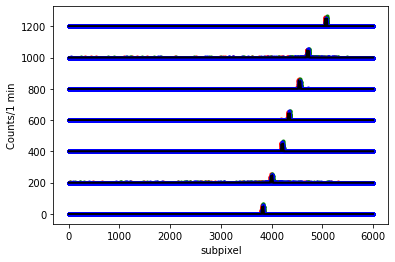

In [17]:
fig = plt.figure()

for i,s in enumerate(scans):
    energy,[ccd1,ccd2,ccd3] = getdata(s)
    offset = 200
    xdata = np.arange(len(ccd1))
    plt.plot(xdata,ccd1+offset*i,marker='.',color = "r")
    plt.plot(xdata,ccd2+offset*i,marker='.', color = "g")
    plt.plot(xdata,ccd3+offset*i,marker='.', color = "b")
    en,[mu1,sig1,amp1,mu2,sig2,amp2,mu3,sig3,amp3]= getdatafit(s)
    plt.plot(xdata,gaussian_norm(xdata,mu1,sig1,amp1)+offset*i,'-',color = "black")
    plt.plot(xdata,gaussian_norm(xdata,mu2,sig2,amp2)+offset*i,'-',color = "black")
    plt.plot(xdata,gaussian_norm(xdata,mu3,sig3,amp3)+offset*i,'-',color = "black")
    
plt.xlabel('subpixel')
plt.ylabel('Counts/1 min')
# plt.savefig(str(today)+'_'+base+'_'+'drift.pdf',dpi=600,format='pdf')


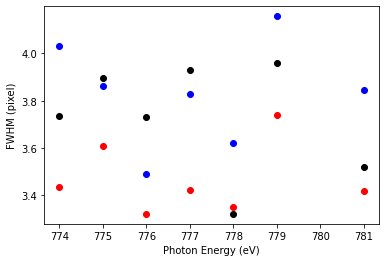

In [18]:
fig = plt.figure()

for i,s in enumerate(scans):

    en,[mu1,sigma1,amp1,mu2,sigma2,amp2,mu3,sigma3,amp3]= getdatafit(s)
    plt.plot(en,sigma1*2.355/4,'o',color = "black")
    plt.plot(en,sigma2*2.355/4,'o',color = "red")
    plt.plot(en,sigma3*2.355/4,'o',color = "blue")
    
plt.xlabel('Photon Energy (eV)')
plt.ylabel('FWHM (pixel)')
# plt.savefig(str(today)+'_'+base+'_'+'FWHM.pdf',dpi=600,format='pdf')

In [19]:
fwhm1 = []
fwhm2 = []
fwhm3 = []
center1 = []
center2 = []
center3 = []
energy = []

for i,s in enumerate(scans):
    en,[mu1,sigma1,amp1,mu2,sigma2,amp2,mu3,sigma3,amp3]= getdatafit(s)
    energy.append(en)
    fwhm1.append(sigma1*2.355)
    center1.append(mu1)
    fwhm2.append(sigma2*2.355)
    center2.append(mu2)
    fwhm3.append(sigma3*2.355)
    center3.append(mu3)

[myslope1,myinter1] = np.polyfit(energy,center1,1)
[myslope2,myinter2] = np.polyfit(energy,center2,1)
[myslope3,myinter3] = np.polyfit(energy,center3,1)
energypersubpixel = 3.0/(myslope1+myslope2+myslope3)

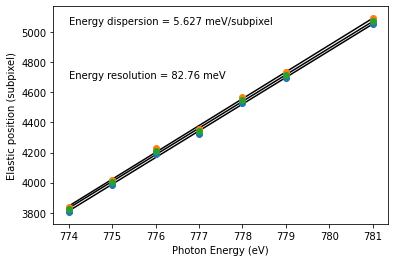

In [20]:
xplot = np.linspace(energy[0],energy[-1],100)
plt.figure()
plt.errorbar(energy,center1,yerr=fwhm1,xerr=None,linewidth=0,marker = "o")
plt.errorbar(energy,center2,yerr=fwhm2,xerr=None,linewidth=0,marker = "o")
plt.errorbar(energy,center3,yerr=fwhm3,xerr=None,linewidth=0,marker = "o")
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Elastic position (subpixel)')
plt.plot(xplot,myslope1*xplot+myinter1, color = 'black')
plt.plot(xplot,myslope2*xplot+myinter2, color = 'black')
plt.plot(xplot,myslope3*xplot+myinter3, color = 'black')
plt.annotate('Energy dispersion = '+str(round(energypersubpixel*1000,3))+' meV/subpixel',xy = (energy[0],center1[-1]))
plt.annotate('Energy resolution = '+str(round(np.mean(fwhm1+fwhm2+fwhm3)*energypersubpixel*1000,3))+' meV',xy = (energy[0],center1[-2]))
plt.savefig(str(today)+'_'+base+'_'+'slope.pdf',dpi=600,format='pdf')

In [21]:
print('Energy dispersion = '+str(round(energypersubpixel*1000,3))+' meV/subpixel')
print('Energy resolution = '+str(round(np.mean(fwhm1+fwhm2+fwhm3)*energypersubpixel*1000,3))+' meV')

Energy dispersion = 5.627 meV/subpixel
Energy resolution = 82.76 meV
